## WGAN Downscaling Using UNET Generator and PathGAN

### Import Library

In [2]:
# type:ignore
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import glob
# import tensorflow_addons as tfa
import shutil
import h5py
import gc
import time

from pathlib import Path
from datetime import datetime
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from myLibrary import inversTransform, inverseLogTransform, image2Xarray, selectPrecipitation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
 # Import utility untuk plotting model
from tensorflow.keras.utils import plot_model


### Configuration parameters

In [3]:
# Configuration parameters
class Config:
    # Data parameters
    # Tidak perlu direktori khusus karena data sudah dimuat dalam variabel
    
    # Input parameters
    LOW_RES_SIZE = (8, 24)    # Ukuran input resolusi rendah sesuai data Anda
    HIGH_RES_SIZE = (32, 96)  # Ukuran output resolusi tinggi sesuai data Anda
    CHANNELS = 1              # Jumlah channel (hanya presipitasi)
    
    # Model parameters
    LEARNING_RATE_G = 1e-4
    LEARNING_RATE_D = 1e-4
    LAMBDA_PIXEL = 100.0      # Weight for pixel-wise loss
    LAMBDA_GRADIENT = 10.0    # Weight for gradient penalty (WGAN-GP)
    
    # Paths (jika diperlukan untuk menyimpan model/hasil)
    MODEL_SAVE_DIR = "models/"
    RESULTS_DIR = "results/"

# Create directories if they don't exist
os.makedirs(Config.MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define all parameters
datasetsName    = 'JI_LT_N_025_01'
modelName       = 'GAN'
version         = '1'
ReportFolder    = modelName + "_" + datasetsName + "_" + version
Normalized      = True
DoPreProcessing = True
learningRate    = 1e-4
batch_size      = 32
numEpochs       = 200

In [5]:
# Path Define
# Get the absolute path 
pathNow = Path().parent.absolute() #See @Arminius answer
pathNow = pathNow.parent
print(pathNow)

# Define the base directory where MSWEP files are stored
datasetsDir     = str(pathNow) + "\\Datasets\\" + datasetsName

# Define HDF5 file name
hdf5Training    = datasetsDir + "\mswepTrain.h5"
hdf5Validation  = datasetsDir + "\mswepValidation.h5"
hdf5Testing     = datasetsDir + "\mswepTesting.h5"
print(hdf5Training)

# Report Filename
ReportFolder    =  str(pathNow) + "\\Reports\\" + ReportFolder 
# Create folder and delete if exists
if os.path.exists(ReportFolder):
    shutil.rmtree(ReportFolder)
os.makedirs(ReportFolder) 
os.makedirs(ReportFolder + '/Graph') 

plotGen         = ReportFolder + '/'+ 'Generator.png'
plotDisc        = ReportFolder + '/'+ 'Discriminator.png'
fileNameModel   = ReportFolder + '/'+ 'CallbacksModel.keras'
fileNameReport  = ReportFolder + '/'+ 'Report.csv'
fileNameHist    = ReportFolder + '/'+ 'Histogram.csv'
print(ReportFolder)


d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code
d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Datasets\JI_LT_N_025_01\mswepTrain.h5
d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Reports\GAN_JI_LT_N_025_01_4


In [6]:
with h5py.File(hdf5Training, "r") as hf:
    precipTrainOriginal = hf["precipTrainOriginal"][:]
    precipLowResTrain   = hf["precipLowResTrain"][:]
    precipHighResTrain  = hf["precipHighResTrain"][:]
    
    timeOriginalTrain   = hf["timeOriginalTrain"][:]
    timeHighResTrain    = hf["timeHighResTrain"][:]
    timeLowResTrain     = hf["timeLowResTrain"][:]
    
    latOriginal         = hf["latOriginal"][:]
    lonOriginal         = hf["lonOriginal"][:]
    latLowRes           = hf["latLowRes"][:]
    lonLowRes           = hf["lonLowRes"][:]
    latHighRes          = hf["latHighRes"][:]
    lonHighRes          = hf["lonHighRes"][:]
    
    if Normalized:
        scale_          = hf["scale_"][:]           # Loading Min Max Scaler Parameter
        min_            = hf["min_"][:]
        data_min_       = hf["data_min_"][:]
        data_max_       = hf["data_max_"][:]
        feature_range   = hf["feature_range"][:]        
    print("Loaded Original Train Data Shape:", precipHighResTrain.shape)

with h5py.File(hdf5Validation, "r") as hf:
    precipValOriginal   = hf["precipValOriginal"][:]
    precipLowResVal     = hf["precipLowResVal"][:]
    precipHighResVal    = hf["precipHighResVal"][:]
    
    timeOriginalVal     = hf["timeOriginalVal"][:]
    timeHighResVal      = hf["timeHighResVal"][:]
    timeLowResVal       = hf["timeLowResVal"][:]
    
    print("Loaded Original Validation Data Shape:", precipHighResVal.shape)
    
with h5py.File(hdf5Testing, "r") as hf:
    precipTestOriginal  = hf["precipTestOriginal"][:]
    precipLowResTest    = hf["precipLowResTest"][:]
    precipHighResTest   = hf["precipHighResTest"][:]
    
    timeOriginalTest    = hf["timeOriginalTest"][:]
    timeHighResTest     = hf["timeHighResTest"][:]
    timeLowResTest      = hf["timeLowResTest"][:]
    
    print("Loaded Original Test Data Shape:", precipHighResTest.shape)   

Loaded Original Train Data Shape: (5113, 32, 96, 1)
Loaded Original Validation Data Shape: (1096, 32, 96, 1)
Loaded Original Test Data Shape: (1096, 32, 96, 1)


In [7]:
#input format (TensorFlow format: [Samples, Height, Width, Channels])
print("Shape Data Train Original", precipTrainOriginal.shape)
print("Shape Data Train Low Res", precipLowResTrain.shape)
print("Shape Data Train High Res", precipHighResTrain.shape)
print("\n")

print("Shape Data Validation Original", precipValOriginal.shape)
print("Shape Data Validation Low Res", precipLowResVal.shape)
print("Shape Data Validation High Res", precipHighResVal.shape)
print("\n")

print("Shape Data Test Original", precipTestOriginal.shape)
print("Shape Data Test Low Res", precipLowResTest.shape)
print("Shape Data Test High Res", precipHighResTest.shape)

Shape Data Train Original (5113, 32, 96, 1)
Shape Data Train Low Res (5113, 14, 38, 1)
Shape Data Train High Res (5113, 32, 96, 1)


Shape Data Validation Original (1096, 32, 96, 1)
Shape Data Validation Low Res (1096, 14, 38, 1)
Shape Data Validation High Res (1096, 32, 96, 1)


Shape Data Test Original (1096, 32, 96, 1)
Shape Data Test Low Res (1096, 14, 38, 1)
Shape Data Test High Res (1096, 32, 96, 1)


In [8]:
print("Nilai Maksimum Train Original", np.max(precipTrainOriginal))
print("Nilai Maksimum Train Low Res", np.max(precipLowResTrain))
print("Nilai Maksimum Train High Res", np.max(precipHighResTrain))
print("\n")

print("Nilai Maksimum Validation Original", np.max(precipValOriginal))
print("Nilai Maksimum Validation Low Res", np.max(precipLowResVal))
print("Nilai Maksimum Validation High Res", np.max(precipHighResVal))
print("\n")

print("Nilai Maksimum Test Original", np.max(precipTestOriginal))
print("Nilai Maksimum Test Low Res", np.max(precipLowResTest))
print("Nilai Maksimum Test High Res", np.max(precipHighResTest))

Nilai Maksimum Train Original 1.0
Nilai Maksimum Train Low Res 0.945680856565271
Nilai Maksimum Train High Res 0.9411113005093045


Nilai Maksimum Validation Original 0.98680305
Nilai Maksimum Validation Low Res 0.9500319930009913
Nilai Maksimum Validation High Res 0.9301632349864115


Nilai Maksimum Test Original 0.95197105
Nilai Maksimum Test Low Res 0.9260518297173248
Nilai Maksimum Test High Res 0.90282142908102


### Data Loading and Preprocessing

In [9]:
def load_and_preprocess_data():
    """
    Load and preprocess the low-resolution and high-resolution precipitation data.
    Returns train, validation, and test datasets as TensorFlow datasets.
    """
    print("Loading and preprocessing data...")
    
    # Menggunakan dataset yang sudah dimuat
    # Data sudah dalam format yang benar:
    # - precipHighResTrain: Data resolusi tinggi hasil interpolasi (input)
    # - precipTrainOriginal: Data original resolusi tinggi (target)
    
    def create_dataset(high_res_interpolated, original_data, is_training=False):
        # Pastikan tipe data adalah float32 untuk TensorFlow
        high_res_interpolated = high_res_interpolated.astype(np.float32)
        original_data = original_data.astype(np.float32)
        
        # Normalisasi data jika diperlukan
        if Normalized:
            # Simpan statistik untuk denormalisasi nanti
            epsilon = 1e-6
            
            # Normalisasi input (data yang diinterpolasi)
            high_res_min = np.min(high_res_interpolated)
            high_res_max = np.max(high_res_interpolated)
            high_res_interpolated = (high_res_interpolated - high_res_min) / (high_res_max - high_res_min + epsilon)
            
            # Normalisasi target (data original)
            original_min = np.min(original_data)
            original_max = np.max(original_data)
            original_data = (original_data - original_min) / (original_max - original_min + epsilon)
            
            # Simpan statistik normalisasi
            norm_stats = {
                "high_res_min": high_res_min,
                "high_res_max": high_res_max,
                "original_min": original_min,
                "original_max": original_max
            }
        else:
            norm_stats = None
        
        # Buat TensorFlow dataset
        dataset = tf.data.Dataset.from_tensor_slices((high_res_interpolated, original_data))
        
        if is_training:
            dataset = dataset.shuffle(buffer_size=1000)
        
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset, norm_stats
    
    # Buat dataset untuk training, validation, dan testing
    train_dataset, train_stats = create_dataset(precipHighResTrain, precipTrainOriginal, is_training=True)
    val_dataset, _ = create_dataset(precipHighResVal, precipValOriginal)
    test_dataset, _ = create_dataset(precipHighResTest, precipTestOriginal)
    
    print(f"Training samples: {precipTrainOriginal.shape[0]}")
    print(f"Validation samples: {precipValOriginal.shape[0]}")
    print(f"Testing samples: {precipTestOriginal.shape[0]}")
    
    return train_dataset, val_dataset, test_dataset, train_stats

### Model Architecture

#### Generator Model using UNET Architecture

In [ ]:
def build_generator():
    """
    Build the generator model (U-Net architecture)
    Input dan output memiliki dimensi yang sama (32, 96, 1)
    """
    # Input layer - Data resolusi tinggi hasil interpolasi
    input_layer = Input(shape=(32, 96, 1))  # precipHighResTrain shape
    
    # Encoder
    # Block 1
    conv1 = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)  # (16, 48, 64)
    
    # Block 2
    conv2 = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)  # (8, 24, 128)
    
    # Block 3
    conv3 = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)  # (4, 12, 256)
    
    # Block 4
    conv4 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)  # (2, 6, 512)
    
    # Decoder
    # Block 5
    deconv5 = layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(conv4)
    deconv5 = BatchNormalization()(deconv5)
    deconv5 = layers.ReLU()(deconv5)
    deconv5 = Concatenate()([deconv5, conv3])  # (4, 12, 512)
    
    # Block 6
    deconv6 = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(deconv5)
    deconv6 = BatchNormalization()(deconv6)
    deconv6 = layers.ReLU()(deconv6)
    deconv6 = Concatenate()([deconv6, conv2])  # (8, 24, 256)
    
    # Block 7
    deconv7 = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(deconv6)
    deconv7 = BatchNormalization()(deconv7)
    deconv7 = layers.ReLU()(deconv7)
    deconv7 = Concatenate()([deconv7, conv1])  # (16, 48, 128)
    
    # Block 8 - Final upsampling to reach original resolution
    deconv8 = layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(deconv7)
    deconv8 = layers.ReLU()(deconv8)  # (32, 96, 32)
    
    # Output layer
    output_layer = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(deconv8)  # (32, 96, 1)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name="generator")
    return model







#### Discriminator Model using PatchGAN

In [ ]:
def build_discriminator():
    """
    Build the discriminator model (PatchGAN)
    Input: (32, 96, 1)
    """
    # Input layer for high-resolution images
    input_layer = Input(shape=(32, 96, 1))
    
    # Block 1
    conv1 = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)  # (16, 48, 64)
    
    # Block 2
    conv2 = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)  # (8, 24, 128)
    
    # Block 3
    conv3 = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)  # (4, 12, 256)
    
    # Block 4
    conv4 = Conv2D(512, (4, 4), strides=(2, 2), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = LeakyReLU(alpha=0.2)(conv4)  # (2, 6, 512)
    
    # Output layer
    output_layer = Conv2D(1, (4, 4), padding='same')(conv4)  # (2, 6, 1)
    
    # Create model
    model = Model(inputs=input_layer, outputs=output_layer, name="discriminator")
    return model

#### Wesserstein Loss

In [ ]:
class WGAN(keras.Model):
    """
    Implementation of WGAN-GP for precipitation downscaling
    """
    def __init__(self, discriminator, generator, lambda_gp=10.0):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.lambda_gp = lambda_gp
        self.lambda_pixel = 100.0  # Weight for pixel-wise loss
        
        # Gunakan learning rate yang telah didefinisikan
        self.d_optimizer = keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE_D, beta_1=0.5, beta_2=0.9)
        self.g_optimizer = keras.optimizers.Adam(learning_rate=Config.LEARNING_RATE_G, beta_1=0.5, beta_2=0.9)
        
        # Initialize metrics
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.gp_metric = keras.metrics.Mean(name="gradient_penalty")
        self.l1_metric = keras.metrics.Mean(name="l1_loss")
        
        # Loss trackers for plotting
        self.d_loss_history = []
        self.g_loss_history = []
        self.l1_loss_history = []
    
    def gradient_penalty(self, real_images, fake_images):
        """
        Calculate gradient penalty for WGAN-GP
        """
        batch_size = tf.shape(real_images)[0]
        
        # Generate random interpolation factors
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        
        # Create interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        
        # Calculate gradients with respect to inputs
        gradients = tape.gradient(pred, interpolated)
        
        # Compute the Euclidean norm of the gradients
        gradients_sqr = tf.square(gradients)
        gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=[1, 2, 3])
        gradient_l2_norm = tf.sqrt(gradients_sqr_sum)
        
        # Compute gradient penalty
        gradient_penalty = tf.reduce_mean(tf.square(gradient_l2_norm - 1.0))
        
        return gradient_penalty
    
    def compile(self):
        super(WGAN, self).compile()
    
    @tf.function
    def train_step(self, data):
        high_res_interpolated, original_data = data  # Renamed for clarity
        batch_size = tf.shape(high_res_interpolated)[0]
        
        # Train discriminator
        for i in range(1):  # Can use multiple discriminator updates per generator update
            with tf.GradientTape() as tape:
                # Generate fake images
                fake_high_res = self.generator(high_res_interpolated, training=True)
                
                # Get discriminator outputs for real and fake
                fake_logits = self.discriminator(fake_high_res, training=True)
                real_logits = self.discriminator(original_data, training=True)
                
                # WGAN loss
                d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
                
                # Gradient penalty
                gp = self.gradient_penalty(original_data, fake_high_res)
                
                # Total discriminator loss
                d_loss = d_cost + self.lambda_gp * gp
            
            # Get gradients and update discriminator
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Train generator
        with tf.GradientTape() as tape:
            # Generate fake images
            fake_high_res = self.generator(high_res_interpolated, training=True)
            
            # Generator adversarial loss
            fake_logits = self.discriminator(fake_high_res, training=True)
            g_adv_loss = -tf.reduce_mean(fake_logits)
            
            # Content loss (L1)
            l1_loss = tf.reduce_mean(tf.abs(original_data - fake_high_res))
            
            # Total generator loss
            g_loss = g_adv_loss + self.lambda_pixel * l1_loss
        
        # Get gradients and update generator
        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))
        
        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        self.gp_metric.update_state(gp)
        self.l1_metric.update_state(l1_loss)
        
        # Track loss history
        self.d_loss_history.append(float(self.d_loss_metric.result()))
        self.g_loss_history.append(float(self.g_loss_metric.result()))
        self.l1_loss_history.append(float(self.l1_metric.result()))
        
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "gradient_penalty": self.gp_metric.result(),
            "l1_loss": self.l1_metric.result()
        }

### Training and Evaluation

In [11]:
def train_model(train_dataset, val_dataset, epochs=numEpochs):
    """
    Train the GAN model
    """
    # Build models
    generator = build_generator()
    discriminator = build_discriminator()
    
    # Print model summaries
    generator.summary()
    discriminator.summary()

        # Plot model - perbaikan: gunakan objek model, bukan fungsi builder
    try: 
        # Plot generator
        plot_model(generator, to_file=plotGen, show_shapes=True, show_layer_names=True, dpi=100)
        print(f"Generator model plot saved to {plotGen}")
        
        # Plot discriminator
        plot_model(discriminator, to_file=plotDisc, show_shapes=True, show_layer_names=True, dpi=100)
        print(f"Discriminator model plot saved to {plotDisc}")
    except Exception as e:
        print(f"Model plotting failed: {e}")
        print("Continuing without plotting models")
    
    # Create WGAN model
    wgan = WGAN(discriminator, generator, lambda_gp=10.0)  # Menggunakan nilai default 10.0
    wgan.compile()
    
    # Training history
    history = {
        "d_loss": [],
        "g_loss": [],
        "val_psnr": [],
        "val_ssim": []
    }
    
    # Evaluation function
    def evaluate_model():
        psnr_values = []
        ssim_values = []
        
        for high_res_interpolated_batch, original_batch in val_dataset.take(10):  # Evaluasi pada 10 batch
            generated_images = generator.predict(high_res_interpolated_batch)
            
            # Calculate PSNR
            psnr = tf.image.psnr(original_batch, generated_images, max_val=1.0)
            psnr_values.append(tf.reduce_mean(psnr))
            
            # Calculate SSIM
            ssim = tf.image.ssim(original_batch, generated_images, max_val=1.0)
            ssim_values.append(tf.reduce_mean(ssim))
        
        return np.mean(psnr_values), np.mean(ssim_values)
    
    # Create sample examples for visualization during training
    visualize_high_res_interpolated = None
    visualize_original = None
    
    for high_res_interpolated_batch, original_batch in val_dataset.take(1):
        visualize_high_res_interpolated = high_res_interpolated_batch[:4]  # Ambil 4 sampel
        visualize_original = original_batch[:4]
    
    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train for one epoch
        for step, (high_res_interpolated_batch, original_batch) in enumerate(train_dataset):
            metrics = wgan.train_step((high_res_interpolated_batch, original_batch))
            
            if step % 50 == 0:
                print(f"Step {step}: d_loss = {metrics['d_loss']:.4f}, g_loss = {metrics['g_loss']:.4f}, l1_loss = {metrics['l1_loss']:.4f}")
        
        # Evaluate on validation set
        val_psnr, val_ssim = evaluate_model()
        
        # Update history
        history["d_loss"].append(float(wgan.d_loss_metric.result()))
        history["g_loss"].append(float(wgan.g_loss_metric.result()))
        history["val_psnr"].append(float(val_psnr))
        history["val_ssim"].append(float(val_ssim))
        
        # Reset metrics
        wgan.d_loss_metric.reset_states()
        wgan.g_loss_metric.reset_states()
        wgan.gp_metric.reset_states()
        wgan.l1_metric.reset_states()
        
        print(f"Epoch {epoch+1}: d_loss = {history['d_loss'][-1]:.4f}, g_loss = {history['g_loss'][-1]:.4f}, "
              f"val_psnr = {val_psnr:.4f}, val_ssim = {val_ssim:.4f}")
        
        # Generate and save sample images
        if epoch % 10 == 0 or epoch == epochs - 1:
            generate_and_save_images(generator, epoch, visualize_high_res_interpolated, visualize_original)
        
        # Save model checkpoints
        if epoch % 20 == 0 or epoch == epochs - 1:
            generator.save(os.path.join(ReportFolder, f"generator_epoch_{epoch+1}.keras"))
            discriminator.save(os.path.join(ReportFolder, f"discriminator_epoch_{epoch+1}.keras"))
    
    # Save final models
    generator.save(os.path.join(ReportFolder, "generator_final.keras"))
    discriminator.save(os.path.join(ReportFolder, "discriminator_final.keras"))
    
    # Plot training history
    plot_training_history(history)
    
    return generator, discriminator, history


def generate_and_save_images(model, epoch, high_res_interpolated, original):
    """
    Generate and save images during training
    """
    # Generate images from high-res interpolated inputs
    generated_images = model.predict(high_res_interpolated)
    
    # Create figure (mempertimbangkan ukuran data 32x96)
    fig = plt.figure(figsize=(15, 10))
    
    for i in range(4):
        # High-res interpolated input
        plt.subplot(4, 3, i*3 + 1)
        plt.imshow(high_res_interpolated[i, :, :, 0], cmap='Blues')
        plt.colorbar()
        plt.axis('off')
        if i == 0:
            plt.title('Interpolated Input')
        
        # Generated result
        plt.subplot(4, 3, i*3 + 2)
        plt.imshow(generated_images[i, :, :, 0], cmap='Blues')
        plt.colorbar()
        plt.axis('off')
        if i == 0:
            plt.title('Generated Output')
        
        # Original data
        plt.subplot(4, 3, i*3 + 3)
        plt.imshow(original[i, :, :, 0], cmap='Blues')
        plt.colorbar()
        plt.axis('off')
        if i == 0:
            plt.title('Original Data')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', f'image_at_epoch_{epoch+1}.png'))
    plt.close()


def plot_training_history(history):
    """
    Plot training history
    """
    plt.figure(figsize=(12, 10))
    
    # Plot discriminator and generator loss
    plt.subplot(2, 2, 1)
    plt.plot(history['d_loss'], label='Discriminator Loss')
    plt.plot(history['g_loss'], label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN Losses')
    
    # Plot PSNR
    plt.subplot(2, 2, 2)
    plt.plot(history['val_psnr'])
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('Validation PSNR')
    
    # Plot SSIM
    plt.subplot(2, 2, 3)
    plt.plot(history['val_ssim'])
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('Validation SSIM')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', 'training_history.png'))
    plt.close()

### Evaluation Metrics

In [12]:
def evaluate_precipitation_metrics(generator, test_dataset, stats):
    """
    Evaluate precipitation-specific metrics on the test set
    """
    print("\nEvaluating precipitation-specific metrics...")
    
    # Initialize metrics
    metrics = {
        "rmse": [],
        "psnr": [],
        "ssim": [],
        "bias": [],
        "correlation": [],
        "wet_day_frequency_diff": []  # Difference in wet day frequency
    }
    
    # Threshold for wet day (in original scale, not normalized)
    # Typical value is 1 mm/day
    wet_day_threshold = 1.0
    
    # Function to inverse transform normalized data to original scale
    def inverse_transform(data, data_min, data_max, epsilon=1e-6):
        # Denormalisasi - mengubah nilai [0,1] kembali ke nilai asli
        data_denorm = data * (data_max - data_min) + data_min
        return data_denorm
    
    # Process test batches
    sample_count = 0
    for high_res_interpolated, original_data in test_dataset:
        # Generate predictions
        generated_batch = generator.predict(high_res_interpolated)
        
        # Convert back to original scale if normalization was applied
        if Normalized:
            original_data_denorm = inverse_transform(
                original_data.numpy(), 
                stats["original_min"], 
                stats["original_max"]
            )
            
            generated_denorm = inverse_transform(
                generated_batch, 
                stats["original_min"], 
                stats["original_max"]
            )
        else:
            original_data_denorm = original_data.numpy()
            generated_denorm = generated_batch
        
        # Calculate metrics for this batch
        batch_size = original_data.shape[0]
        for i in range(batch_size):
            original = original_data_denorm[i, :, :, 0]
            generated = generated_denorm[i, :, :, 0]
            
            # RMSE
            rmse = np.sqrt(np.mean((original - generated) ** 2))
            metrics["rmse"].append(rmse)
            
            # PSNR (using TensorFlow's function on normalized data)
            psnr = tf.image.psnr(original_data[i:i+1], generated_batch[i:i+1], max_val=1.0)
            metrics["psnr"].append(psnr.numpy()[0])
            
            # SSIM (using TensorFlow's function on normalized data)
            ssim = tf.image.ssim(original_data[i:i+1], generated_batch[i:i+1], max_val=1.0)
            metrics["ssim"].append(ssim.numpy()[0])
            
            # Bias
            bias = np.mean(generated - original)
            metrics["bias"].append(bias)
            
            # Correlation
            flat_original = original.flatten()
            flat_generated = generated.flatten()
            correlation = np.corrcoef(flat_original, flat_generated)[0, 1]
            metrics["correlation"].append(correlation)
            
            # Wet day frequency
            original_wet_freq = np.mean(original > wet_day_threshold)
            generated_wet_freq = np.mean(generated > wet_day_threshold)
            metrics["wet_day_frequency_diff"].append(abs(original_wet_freq - generated_wet_freq))
        
        sample_count += batch_size
        
        # Limit evaluation to a reasonable number of samples
        if sample_count >= 1000:
            break
    
    # Print average metrics
    print(f"\nEvaluation on {sample_count} test samples:")
    print(f"RMSE: {np.mean(metrics['rmse']):.4f} mm/day")
    print(f"PSNR: {np.mean(metrics['psnr']):.4f} dB")
    print(f"SSIM: {np.mean(metrics['ssim']):.4f}")
    print(f"Bias: {np.mean(metrics['bias']):.4f} mm/day")
    print(f"Correlation: {np.mean(metrics['correlation']):.4f}")
    print(f"Wet day frequency difference: {np.mean(metrics['wet_day_frequency_diff']):.4f}")
    
    return metrics


def visualize_precipitation_distribution(generator, test_dataset, stats, num_samples=100):
    """
    Visualize the precipitation distribution of real vs generated data
    """
    print("\nVisualizing precipitation distribution...")
    
    # Initialize arrays to store real and generated precipitation values
    real_precip = []
    generated_precip = []
    
    # Function to inverse transform normalized data
    def inverse_transform(data, data_min, data_max, epsilon=1e-6):
        data_denorm = data * (data_max - data_min) + data_min
        return data_denorm
    
    # Process test batches
    sample_count = 0
    for high_res_interpolated, original_data in test_dataset:
        # Generate predictions
        generated_batch = generator.predict(high_res_interpolated)
        
        # Convert back to original scale if normalization was applied
        if Normalized:
            original_data_denorm = inverse_transform(
                original_data.numpy(), 
                stats["original_min"], 
                stats["original_max"]
            )
            
            generated_denorm = inverse_transform(
                generated_batch, 
                stats["original_min"], 
                stats["original_max"]
            )
        else:
            original_data_denorm = original_data.numpy()
            generated_denorm = generated_batch
        
        # Collect precipitation values
        batch_size = original_data.shape[0]
        for i in range(batch_size):
            original = original_data_denorm[i, :, :, 0].flatten()
            generated = generated_denorm[i, :, :, 0].flatten()
            
            real_precip.extend(original)
            generated_precip.extend(generated)
        
        sample_count += batch_size
        if sample_count >= num_samples:
            break
    
    # Convert to numpy arrays
    real_precip = np.array(real_precip)
    generated_precip = np.array(generated_precip)
    
    # Remove negative values (artifacts from inverse transformation)
    real_precip = real_precip[real_precip >= 0]
    generated_precip = generated_precip[generated_precip >= 0]
    
    # Plot distribution
    plt.figure(figsize=(12, 8))
    
    # Plot histogram on linear scale
    plt.subplot(2, 2, 1)
    bins = np.linspace(0, np.percentile(real_precip, 99), 50)
    plt.hist(real_precip, bins=bins, density=True, alpha=0.5, label='Original')
    plt.hist(generated_precip, bins=bins, density=True, alpha=0.5, label='Generated')
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('Density')
    plt.title('Precipitation Distribution (Linear Scale)')
    plt.legend()
    
    # Plot histogram on logarithmic scale
    plt.subplot(2, 2, 2)
    bins = np.logspace(-2, np.log10(np.percentile(real_precip, 99)), 50)
    plt.hist(real_precip, bins=bins, density=True, alpha=0.5, label='Original')
    plt.hist(generated_precip, bins=bins, density=True, alpha=0.5, label='Generated')
    plt.xscale('log')
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('Density')
    plt.title('Precipitation Distribution (Log Scale)')
    plt.legend()
    
    # Plot Q-Q plot
    plt.subplot(2, 2, 3)
    real_quantiles = np.quantile(real_precip, np.linspace(0.01, 0.99, 99))
    gen_quantiles = np.quantile(generated_precip, np.linspace(0.01, 0.99, 99))
    plt.scatter(real_quantiles, gen_quantiles)
    plt.plot([0, np.max(real_quantiles)], [0, np.max(real_quantiles)], 'r--')
    plt.xlabel('Original Precipitation Quantiles')
    plt.ylabel('Generated Precipitation Quantiles')
    plt.title('Q-Q Plot')
    
    # Plot CDF
    plt.subplot(2, 2, 4)
    real_sorted = np.sort(real_precip)
    gen_sorted = np.sort(generated_precip)
    plt.plot(real_sorted, np.linspace(0, 1, len(real_sorted)), label='Original')
    plt.plot(gen_sorted, np.linspace(0, 1, len(gen_sorted)), label='Generated')
    plt.xlabel('Precipitation (mm/day)')
    plt.ylabel('CDF')
    plt.title('Cumulative Distribution Function')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', 'precipitation_distribution.png'))
    plt.close()


def visualize_spatial_patterns(generator, test_dataset, stats):
    """
    Visualize spatial patterns of precipitation
    """
    print("\nVisualizing spatial patterns...")
    
    # Get a batch of test data
    for high_res_interpolated, original_data in test_dataset.take(1):
        break
    
    # Generate predictions
    generated_batch = generator.predict(high_res_interpolated)
    
    # Function to inverse transform normalized data
    def inverse_transform(data, data_min, data_max, epsilon=1e-6):
        data_denorm = data * (data_max - data_min) + data_min
        return data_denorm
    
    # Convert back to original scale if normalization was applied
    if Normalized:
        original_data_denorm = inverse_transform(
            original_data.numpy(), 
            stats["original_min"], 
            stats["original_max"]
        )
        
        high_res_interpolated_denorm = inverse_transform(
            high_res_interpolated.numpy(), 
            stats["high_res_min"], 
            stats["high_res_max"]
        )
        
        generated_denorm = inverse_transform(
            generated_batch, 
            stats["original_min"], 
            stats["original_max"]
        )
    else:
        original_data_denorm = original_data.numpy()
        high_res_interpolated_denorm = high_res_interpolated.numpy()
        generated_denorm = generated_batch
    
    # Plot samples from the batch
    num_samples = min(4, high_res_interpolated.shape[0])
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4 * num_samples))
    
    for i in range(num_samples):
        # Input interpolated high-res
        im0 = axes[i, 0].imshow(high_res_interpolated_denorm[i, :, :, 0], cmap='Blues')
        axes[i, 0].set_title('Input (Interpolated)')
        fig.colorbar(im0, ax=axes[i, 0], label='mm/day')
        
        # Generated high-res
        im1 = axes[i, 1].imshow(generated_denorm[i, :, :, 0], cmap='Blues')
        axes[i, 1].set_title('Generated (Enhanced)')
        fig.colorbar(im1, ax=axes[i, 1], label='mm/day')
        
        # Original high-res
        im2 = axes[i, 2].imshow(original_data_denorm[i, :, :, 0], cmap='Blues')
        axes[i, 2].set_title('Original MSWEP')
        fig.colorbar(im2, ax=axes[i, 2], label='mm/day')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', 'spatial_patterns.png'))
    plt.close()
    
    # Compute and visualize difference maps
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 4 * num_samples))
    
    for i in range(num_samples):
        # Absolute error between generated and original
        diff = np.abs(generated_denorm[i, :, :, 0] - original_data_denorm[i, :, :, 0])
        im0 = axes[i, 0].imshow(diff, cmap='Reds')
        axes[i, 0].set_title('Absolute Error')
        fig.colorbar(im0, ax=axes[i, 0], label='mm/day')
        
        # Relative error (where precipitation is significant)
        mask = original_data_denorm[i, :, :, 0] > 0.1  # Only where precipitation > 0.1 mm/day
        rel_diff = np.zeros_like(diff)
        rel_diff[mask] = diff[mask] / original_data_denorm[i, :, :, 0][mask]
        im1 = axes[i, 1].imshow(rel_diff, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[i, 1].set_title('Relative Error')
        fig.colorbar(im1, ax=axes[i, 1], label='Ratio')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', 'error_maps.png'))
    plt.close()


def analyze_extreme_precipitation(generator, test_dataset, stats):
    """
    Analyze extreme precipitation events
    """
    print("\nAnalyzing extreme precipitation events...")
    
    # Initialize lists to store extreme event statistics
    real_extremes = []
    gen_extremes = []
    extreme_similarity = []
    
    # Function to inverse transform normalized data
    def inverse_transform(data, data_min, data_max, epsilon=1e-6):
        data_denorm = data * (data_max - data_min) + data_min
        return data_denorm
    
    # Process test batches
    sample_count = 0
    for high_res_interpolated, original_data in test_dataset:
        # Generate predictions
        generated_batch = generator.predict(high_res_interpolated)
        
        # Convert back to original scale if normalization was applied
        if Normalized:
            original_data_denorm = inverse_transform(
                original_data.numpy(), 
                stats["original_min"], 
                stats["original_max"]
            )
            
            generated_denorm = inverse_transform(
                generated_batch, 
                stats["original_min"], 
                stats["original_max"]
            )
        else:
            original_data_denorm = original_data.numpy()
            generated_denorm = generated_batch
        
        # Analyze each sample in the batch
        batch_size = original_data.shape[0]
        for i in range(batch_size):
            original = original_data_denorm[i, :, :, 0]
            generated = generated_denorm[i, :, :, 0]
            
            # Define extreme threshold (e.g., 95th percentile)
            extreme_threshold = np.percentile(original, 95)
            
            # Identify extreme events in real and generated data
            real_extreme_mask = original > extreme_threshold
            gen_extreme_mask = generated > extreme_threshold
            
            # Calculate statistics for extremes
            real_extremes.append(np.mean(original[real_extreme_mask]) if np.any(real_extreme_mask) else 0)
            gen_extremes.append(np.mean(generated[gen_extreme_mask]) if np.any(gen_extreme_mask) else 0)
            
            # Calculate extreme event spatial overlap (Jaccard similarity)
            intersection = np.logical_and(real_extreme_mask, gen_extreme_mask).sum()
            union = np.logical_or(real_extreme_mask, gen_extreme_mask).sum()
            similarity = intersection / union if union > 0 else 0
            extreme_similarity.append(similarity)
        
        sample_count += batch_size
        if sample_count >= 100:  # Limit to a reasonable number of samples
            break
    
    # Plot extreme event analysis
    plt.figure(figsize=(12, 8))
    
    # Plot extreme event magnitudes
    plt.subplot(2, 2, 1)
    plt.scatter(real_extremes, gen_extremes)
    max_val = max(np.max(real_extremes), np.max(gen_extremes))
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.xlabel('Original Extreme Precipitation (mm/day)')
    plt.ylabel('Generated Extreme Precipitation (mm/day)')
    plt.title('Extreme Event Magnitude Comparison')
    
    # Plot histogram of extreme event similarity
    plt.subplot(2, 2, 2)
    plt.hist(extreme_similarity, bins=20)
    plt.xlabel('Spatial Overlap (Jaccard Similarity)')
    plt.ylabel('Frequency')
    plt.title('Extreme Event Spatial Overlap')
    
    # Display average statistics
    plt.subplot(2, 2, 3)
    avg_real = np.mean(real_extremes)
    avg_gen = np.mean(gen_extremes)
    avg_sim = np.mean(extreme_similarity)
    
    plt.text(0.5, 0.8, f"Avg Original Extreme: {avg_real:.2f} mm/day", ha='center')
    plt.text(0.5, 0.6, f"Avg Generated Extreme: {avg_gen:.2f} mm/day", ha='center')
    plt.text(0.5, 0.4, f"Avg Spatial Overlap: {avg_sim:.2f}", ha='center')
    plt.text(0.5, 0.2, f"Extreme Magnitude Ratio: {avg_gen/avg_real:.2f}", ha='center')
    plt.axis('off')
    plt.title('Extreme Event Statistics')
    
    plt.tight_layout()
    plt.savefig(os.path.join(ReportFolder, 'Graph', 'extreme_precipitation_analysis.png'))
    plt.close()
    
    return {
        "avg_real_extreme": avg_real,
        "avg_gen_extreme": avg_gen,
        "avg_spatial_overlap": avg_sim,
        "extreme_magnitude_ratio": avg_gen/avg_real
    }

In [13]:
print(type((precipHighResVal, precipValOriginal)))

<class 'tuple'>


#### Training Step

In [14]:
#################################################
# Main Function
#################################################

print("Starting Precipitation Downscaling GAN...")
start_time = time.time()

# Load and preprocess data
train_dataset, val_dataset, test_dataset, stats = load_and_preprocess_data()

# Train model
generator, discriminator, history = train_model(train_dataset, val_dataset, epochs=numEpochs)

# Evaluasi model (uncomment jika Anda ingin mengevaluasi)
metrics = evaluate_precipitation_metrics(generator, test_dataset, stats)

# Visualisasi hasil (uncomment jika Anda ingin visualisasi)
visualize_precipitation_distribution(generator, test_dataset, stats)
visualize_spatial_patterns(generator, test_dataset, stats)
extreme_stats = analyze_extreme_precipitation(generator, test_dataset, stats)

print("\nPrecipitation Downscaling GAN Complete!")
print(f"Model and results saved to {ReportFolder}")

Starting Precipitation Downscaling GAN...
Loading and preprocessing data...
Training samples: 5113
Validation samples: 1096
Testing samples: 1096
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 96, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 48, 64)   1088        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 48, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 2

In [15]:
print("Evaluating model on all datasets...")

# Evaluate using training data
print("Evaluate using training data")
keras.backend.clear_session()
gc.collect()
yTrainPreds = generator.predict(
    precipHighResTrain, 
    batch_size=batch_size,
    verbose='auto',
    workers=1
)

# Evaluate using validation data
print("Evaluate using validation data")
keras.backend.clear_session()
gc.collect()
yValPreds = generator.predict(
    precipHighResVal,  
    batch_size=batch_size,
    verbose='auto',
    workers=1
)

# Evaluate using testing data
print("Evaluate using testing data")
keras.backend.clear_session()
gc.collect()
yTestPreds = generator.predict(
    precipHighResTest, 
    batch_size=batch_size,
    verbose='auto',
    workers=1
)

# Tambahan: Jika Anda ingin menyimpan hasil prediksi ke file
np.save(os.path.join(ReportFolder, 'train_predictions.npy'), yTrainPreds)
np.save(os.path.join(ReportFolder, 'val_predictions.npy'), yValPreds)
np.save(os.path.join(ReportFolder, 'test_predictions.npy'), yTestPreds)

end_time = time.time()

print("\nPrecipitation Downscaling Evaluation GAN Complete!")
print(f"Model and results saved to {ReportFolder}")

Evaluating model on all datasets...
Evaluate using training data
160/160 [==============================] - 1s 4ms/step
Evaluate using validation data
35/35 [==============================] - 0s 6ms/step
Evaluate using testing data
35/35 [==============================] - 0s 3ms/step

Precipitation Downscaling Evaluation GAN Complete!
Model and results saved to d:\UNIVERSITAS INDONESIA\BMKG Research 3 - 2025.PrecipitationProjection\Hasan.Code\Reports\GAN_JI_LT_N_025_01_4


In [16]:
print(np.max(yTrainPreds))

0.9170765


#### Invers to Original Data

In [17]:
# Invers to original precipitation data
if Normalized:
    # Recreate Min Max Scaler with saved parameters
    print('Invers to original precipitation data using Min Max Scaller')
    scaler              = MinMaxScaler()
    scaler.scale_       = scale_ 
    scaler.min_         = min_
    scaler.data_min_    = data_min_
    scaler.data_max_    = data_max_
    scaler.feature_range = feature_range
    
    yTrainPreds         = inversTransform(scaler, yTrainPreds)
    yValPreds           = inversTransform(scaler, yValPreds)
    yTestPreds          = inversTransform(scaler, yTestPreds)
    
    precipTrainOriginal = inversTransform(scaler, precipTrainOriginal)
    precipValOriginal   = inversTransform(scaler, precipValOriginal)
    precipTestOriginal  = inversTransform(scaler, precipTestOriginal)
    
    precipLowResTrain   = inversTransform(scaler, precipLowResTrain)
    precipLowResVal     = inversTransform(scaler, precipLowResVal)
    precipLowResTest    = inversTransform(scaler, precipLowResTest)
    
    precipHighResTrain  = inversTransform(scaler, precipHighResTrain)
    precipHighResVal    = inversTransform(scaler, precipHighResVal)
    precipHighResTest   = inversTransform(scaler, precipHighResTest)

# Invers to original precipitation data
if DoPreProcessing:
    print('Invers to original precipitation data using Log Transformation')
    yTrainPreds   = inverseLogTransform(yTrainPreds)
    yValPreds     = inverseLogTransform(yValPreds)
    yTestPreds    = inverseLogTransform(yTestPreds)
    
    precipTrainOriginal = inverseLogTransform(precipTrainOriginal)
    precipValOriginal   = inverseLogTransform(precipValOriginal)
    precipTestOriginal  = inverseLogTransform(precipTestOriginal)
    
    precipLowResTrain   = inverseLogTransform(precipLowResTrain)
    precipLowResVal     = inverseLogTransform(precipLowResVal)
    precipLowResTest    = inverseLogTransform(precipLowResTest)
    
    precipHighResTrain  = inverseLogTransform(precipHighResTrain)
    precipHighResVal    = inverseLogTransform(precipHighResVal)
    precipHighResTest   = inverseLogTransform(precipHighResTest)

Invers to original precipitation data using Min Max Scaller
Invers to original precipitation data using Log Transformation


In [18]:
print(np.max(yTrainPreds))
print(np.max(precipTrainOriginal))

213.6131
344.81244


In [19]:
# Replace negative with the zero
yTrainPreds = np.where(yTrainPreds >= 0, yTrainPreds, 0)
yValPreds   = np.where(yValPreds >= 0, yValPreds, 0)
yTestPreds  = np.where(yTestPreds >= 0, yTestPreds, 0)

In [20]:
import math
# Fungsi pembulatan desimal
def roundDecimal(number, decimal_places=2):
    multiplier = 10 ** decimal_places
    return math.ceil(number * multiplier) / multiplier

# Membuat plot history training untuk model GAN
def plot_gan_history(history, epochs):
    # Plot generator loss dan discriminator loss
    plt.figure(figsize=(10, 6))
    plt.plot(history["g_loss"], label='Generator Loss', color='#1f77b4', linestyle='-', linewidth=1)
    plt.plot(history["d_loss"], label='Discriminator Loss', color='#ff7f0e', linestyle=':', linewidth=1)
    plt.title("GAN Losses", loc='center')
    plt.xlabel("Epochs")
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.ylabel("Loss")
    maxvalue = max(max(history["g_loss"]), max(history["d_loss"]))
    plt.yticks(np.arange(0, maxvalue + maxvalue/10, maxvalue/10))
    plt.legend(loc="upper right")
    plt.axis([0, epochs, 0, maxvalue + maxvalue/10])
    plt.savefig(ReportFolder + '/Graph/1.GAN_Losses.png')
    
    # Plot PSNR
    plt.figure(figsize=(10, 6))
    plt.plot(history["val_psnr"], label='Validation PSNR', color='#2ca02c', linestyle='-', linewidth=1)
    plt.title("Peak Signal-to-Noise Ratio", loc='center')
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.ylabel("PSNR (dB)")
    maxvalue = max(history["val_psnr"])
    plt.yticks(np.arange(0, maxvalue + maxvalue/10, maxvalue/10))
    plt.axis([0, epochs, 0, maxvalue + maxvalue/10])
    plt.legend(loc="lower right")
    plt.savefig(ReportFolder + '/Graph/2.PSNR.png')
    
    # Plot SSIM
    plt.figure(figsize=(10, 6))
    plt.plot(history["val_ssim"], label='Validation SSIM', color='#d62728', linestyle='-', linewidth=1)
    plt.title("Structural Similarity Index", loc='center')
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, epochs + epochs/10, epochs/10))
    plt.ylabel("SSIM")
    maxvalue = max(history["val_ssim"])
    plt.yticks(np.arange(0, maxvalue + maxvalue/10, maxvalue/10))
    plt.axis([0, epochs, 0, maxvalue + maxvalue/10])
    plt.legend(loc="lower right")
    plt.savefig(ReportFolder + '/Graph/3.SSIM.png')

# Plot kurva regresi setelah inverse transform
def plot_regression_curve():
    # Flatten array untuk plotting scatter (dibuat flat untuk plotting)
    original_train_flat = precipTrainOriginal.reshape(-1, 1).flatten()
    pred_train_flat = yTrainPreds.reshape(-1, 1).flatten()
    original_val_flat = precipValOriginal.reshape(-1, 1).flatten()
    pred_val_flat = yValPreds.reshape(-1, 1).flatten()
    original_test_flat = precipTestOriginal.reshape(-1, 1).flatten()
    pred_test_flat = yTestPreds.reshape(-1, 1).flatten()
    
    # Menghitung nilai maksimum untuk akse
    all_values = np.concatenate([
        original_train_flat, pred_train_flat,
        original_val_flat, pred_val_flat,
        original_test_flat, pred_test_flat
    ])
    maxVal = roundDecimal(np.max(all_values), 1)

    # Membuat garis identitas (garis y=x)
    xNorm = np.arange(0, maxVal, maxVal/100)
    yNorm = np.arange(0, maxVal, maxVal/100)
    
    # Membuat plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot()
    plt.scatter(original_train_flat, pred_train_flat, label='Training', color='#1f77b4', s=1, alpha=0.7)
    plt.scatter(original_val_flat, pred_val_flat, label='Validation', color='#ff7f0e', s=1, alpha=0.5)
    plt.scatter(original_test_flat, pred_test_flat, label='Testing', color='#2ca02c', s=1, alpha=0.3)
    plt.plot(xNorm, yNorm, color='red')
    plt.title("Regression Curve", loc='center')
    plt.xlabel("Original Precipitation (mm/day)")
    plt.ylabel("Generated Precipitation (mm/day)")
    plt.axis([0, maxVal, 0, maxVal])
    plt.legend(loc="lower right")
    ax.set_aspect('equal', adjustable='box')
    plt.savefig(ReportFolder + '/Graph/4.CorrelationCurve.png')

# Plot performa model (RMSE, MAE, dll) jika data tersedia
def plot_performance_metrics(metrics_dict):
    plt.figure(figsize=(12, 8))
    
    # Plot sebagai bar chart
    plt.bar(metrics_dict.keys(), metrics_dict.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Model Performance Metrics')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.savefig(ReportFolder + '/Graph/5.PerformanceMetrics.png')

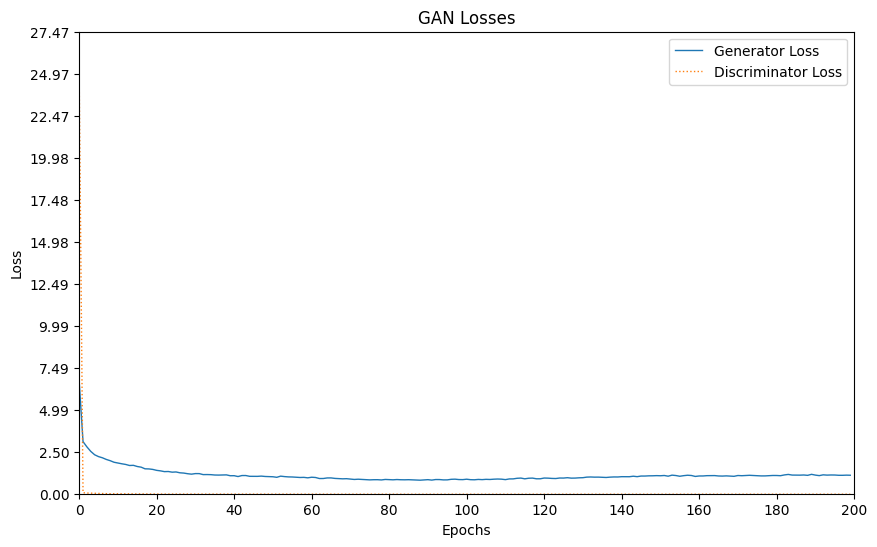

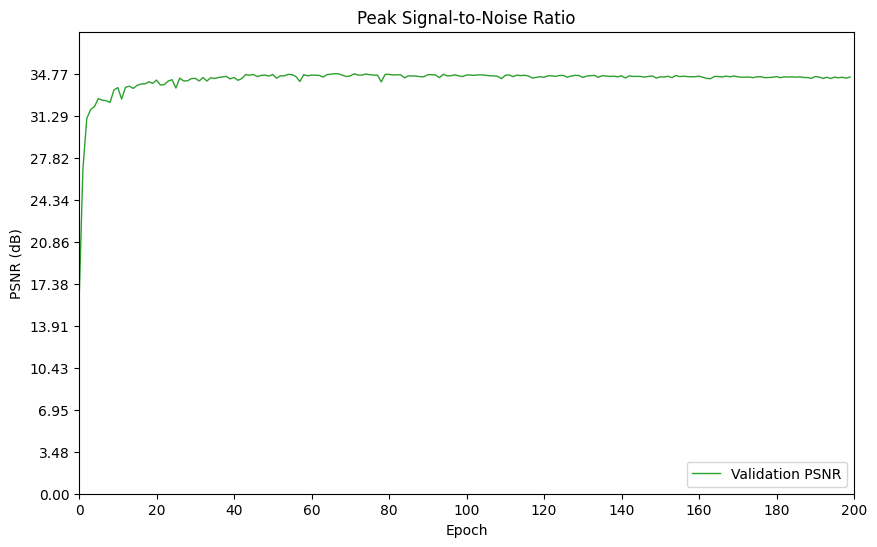

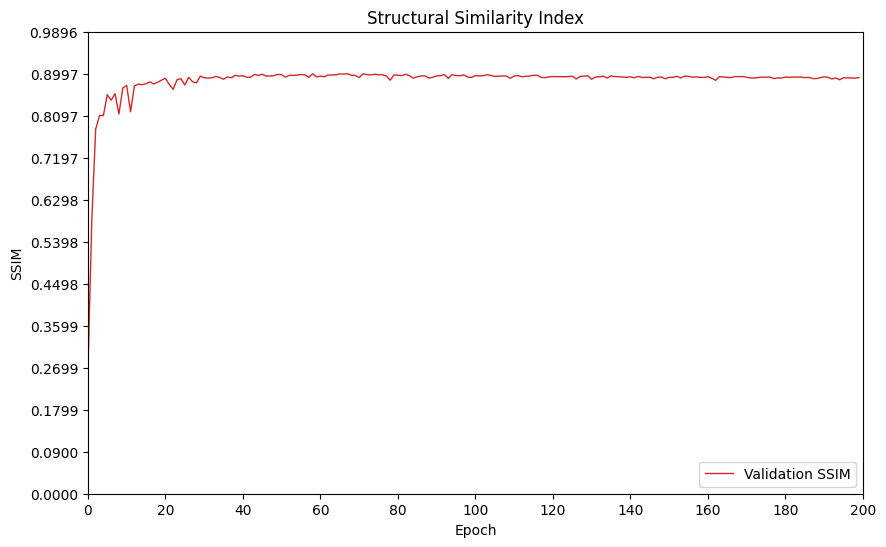

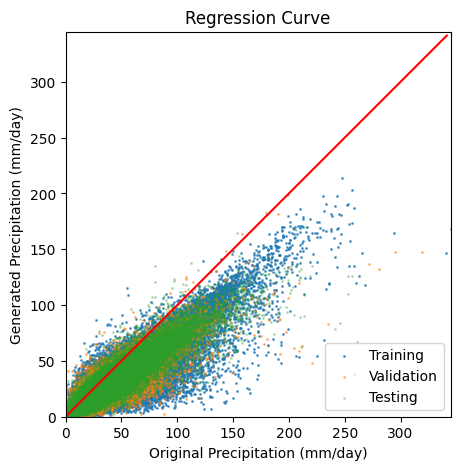

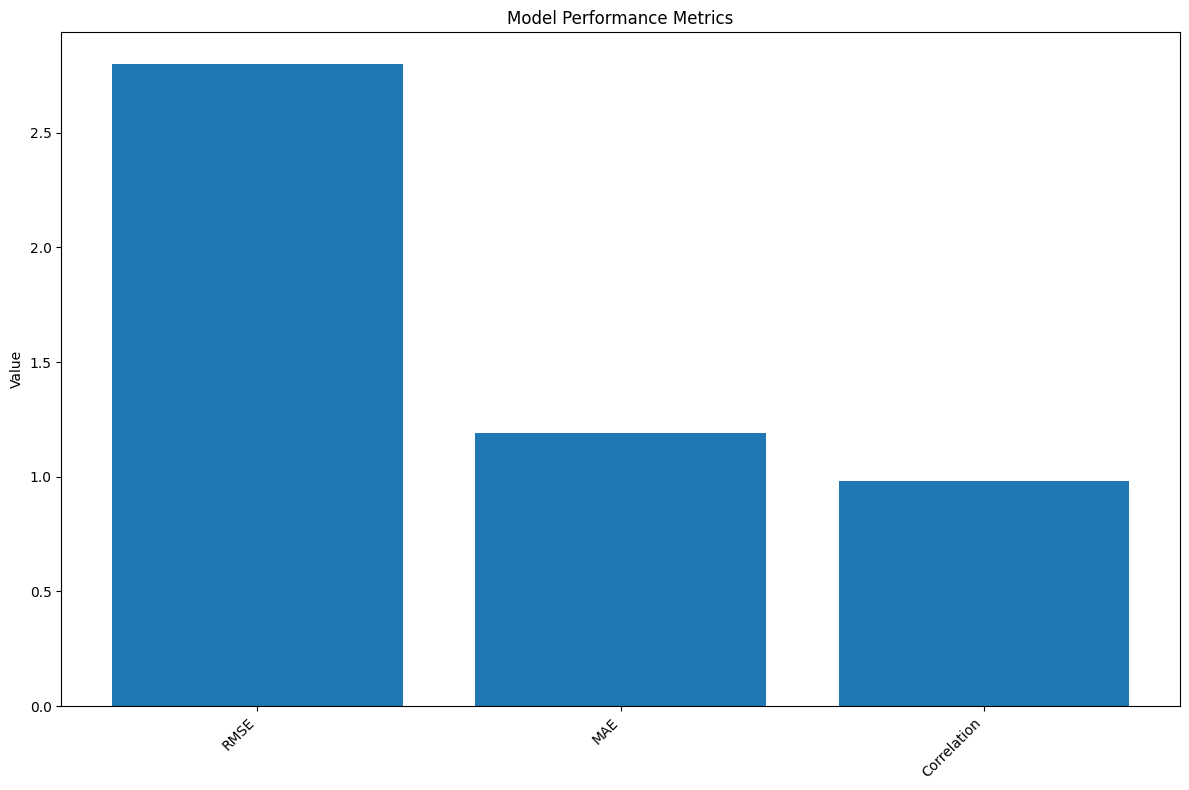

In [21]:
# Setelah melakukan semua inverse transform (normalisasi dan log transform)
# Panggil fungsi plotting

# Plot history training (g_loss, d_loss, val_psnr, val_ssim)
plot_gan_history(history, numEpochs)

# Plot kurva regresi (precipTrainOriginal vs yTrainPreds, dll)
plot_regression_curve()

# Plot metrik performa jika ada (opsional)
metrics = {
    'RMSE': np.sqrt(np.mean((precipTestOriginal - yTestPreds) ** 2)),
    'MAE': np.mean(np.abs(precipTestOriginal - yTestPreds)),
    'Correlation': np.corrcoef(precipTestOriginal.flatten(), yTestPreds.flatten())[0, 1],
    # Tambahkan metrik lain jika diperlukan
}
plot_performance_metrics(metrics)

In [22]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from sklearn.metrics import r2_score
import numpy as np
import scipy.stats as stats

def calculate_kge(obs, sim):
    # Reshape data ke 1D array
    obs_flat = np.array(obs).reshape(-1)
    sim_flat = np.array(sim).reshape(-1)
    
    # Menghitung korelasi Pearson
    r = stats.pearsonr(obs_flat, sim_flat)[0]
    
    # Menghitung rasio standar deviasi
    alpha = np.std(sim_flat) / np.std(obs_flat)
    
    # Menghitung rasio mean
    beta = np.mean(sim_flat) / np.mean(obs_flat)
    
    # Menghitung KGE
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    
    return kge

#### Metrics Measurement

In [23]:
# Simpan waktu akhir training
diffTime = (end_time - start_time) / 60  # konversi ke menit



# Jika history bukan dataframe, konversi ke pandas dataframe
if not isinstance(history, pd.DataFrame):
    # Tambahkan data penting dari history (pastikan kunci sesuai dengan struktur history GAN)
    hist_dict = {
        'g_loss': history.get('g_loss', []),
        'd_loss': history.get('d_loss', []),
        'val_psnr': history.get('val_psnr', []),
        'val_ssim': history.get('val_ssim', [])
    }
    hist_df = pd.DataFrame(hist_dict)
else:
    hist_df = history

# Save history to csv
with open(fileNameHist, mode='w') as f:
    hist_df.to_csv(f)

print('REGRESSION REPORTS')

print('\n')
print('1. Root Mean Squared Error')
rmseTrain = tf.keras.metrics.RootMeanSquaredError()
rmseTrain.update_state(precipTrainOriginal, yTrainPreds)
print('RMSE Train: ' + str(rmseTrain.result().numpy()))

rmseVal = tf.keras.metrics.RootMeanSquaredError()
rmseVal.update_state(precipValOriginal, yValPreds)
print('RMSE Validation: ' + str(rmseVal.result().numpy()))

rmseTest = tf.keras.metrics.RootMeanSquaredError()
rmseTest.update_state(precipTestOriginal, yTestPreds)
print('RMSE Testing: ' + str(rmseTest.result().numpy()))

print('\n')
print('2. Cosine Similarity')
csTrain = tf.keras.metrics.CosineSimilarity()
csTrain.update_state(precipTrainOriginal, yTrainPreds)
print('Cosine Similarity Train: ' + str(csTrain.result().numpy()))

csVal = tf.keras.metrics.CosineSimilarity()
csVal.update_state(precipValOriginal, yValPreds)
print('Cosine Similarity Validation: ' + str(csVal.result().numpy()))

csTest = tf.keras.metrics.CosineSimilarity()
csTest.update_state(precipTestOriginal, yTestPreds)
print('Cosine Similarity Testing: ' + str(csTest.result().numpy()))

print('\n')
print('3.  Coefficient of Determination')
R2Train = r2_score(np.array(precipTrainOriginal).reshape(-1), np.array(yTrainPreds).reshape(-1))
print('R2 score Train: ', R2Train)

R2Val = r2_score(np.array(precipValOriginal).reshape(-1), np.array(yValPreds).reshape(-1))
print('R2 score Val: ', R2Val)

R2Test = r2_score(np.array(precipTestOriginal).reshape(-1), np.array(yTestPreds).reshape(-1))
print('R2 score Test: ', R2Test)

print('\n')
print('4. Mean Absolute Error')
maeTrain = tf.keras.metrics.MeanAbsoluteError()
maeTrain.update_state(precipTrainOriginal, yTrainPreds)
print('Mean Absolute Error Train: ' + str(maeTrain.result().numpy()))

maeVal = tf.keras.metrics.MeanAbsoluteError()
maeVal.update_state(precipValOriginal, yValPreds)
print('Mean Absolute Error Validation: ' + str(maeVal.result().numpy()))

maeTest = tf.keras.metrics.MeanAbsoluteError()
maeTest.update_state(precipTestOriginal, yTestPreds)
print('Mean Absolute Error Testing: ' + str(maeTest.result().numpy()))

print('\n')
print('5. Mean Squared Error')
mseTrain = tf.keras.metrics.MeanSquaredError()
mseTrain.update_state(precipTrainOriginal, yTrainPreds)
print('Mean Squared Error Train: ' + str(mseTrain.result().numpy()))

mseVal = tf.keras.metrics.MeanSquaredError()
mseVal.update_state(precipValOriginal, yValPreds)
print('Mean Squared Error Validation: ' + str(mseVal.result().numpy()))

mseTest = tf.keras.metrics.MeanSquaredError()
mseTest.update_state(precipTestOriginal, yTestPreds)
print('Mean Squared Error Testing: ' + str(mseTest.result().numpy()))

print('\n')
print('6. Mean Absolute Percentage Error')
mapeTrain = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTrain.update_state(precipTrainOriginal, yTrainPreds)
print('Mean Absolute Percentage Error Train: ' + str(mapeTrain.result().numpy()))

mapeVal = tf.keras.metrics.MeanAbsolutePercentageError()
mapeVal.update_state(precipValOriginal, yValPreds)
print('Mean Absolute Percentage Error Validation: ' + str(mapeVal.result().numpy()))

mapeTest = tf.keras.metrics.MeanAbsolutePercentageError()
mapeTest.update_state(precipTestOriginal, yTestPreds)
print('Mean Absolute Percentage Error Testing: ' + str(mapeTest.result().numpy()))

print('\n')
print('7. Peak Signal-to-Noise Ratio (PSNR)')
psnrTrain = tf.image.psnr(precipTrainOriginal, yTrainPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Train: ' + str(tf.reduce_mean(psnrTrain).numpy()))

psnrVal = tf.image.psnr(precipValOriginal, yValPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Validation: ' + str(tf.reduce_mean(psnrVal).numpy()))

psnrTest = tf.image.psnr(precipTestOriginal, yTestPreds, max_val=500)
print('Peak Signal-to-Noise Ratio (PSNR) Testing: ' + str(tf.reduce_mean(psnrTest).numpy()))

print('\n')
print('8. Structural Similarity Index (SSIM)')
ssimTrain = tf.image.ssim(precipTrainOriginal, yTrainPreds, max_val=500)
print('SSIM Train: ' + str(tf.reduce_mean(ssimTrain).numpy()))

ssimVal = tf.image.ssim(precipValOriginal, yValPreds, max_val=500)
print('SSIM Validation: ' + str(tf.reduce_mean(ssimVal).numpy()))

ssimTest = tf.image.ssim(precipTestOriginal, yTestPreds, max_val=500)
print('SSIM Testing: ' + str(tf.reduce_mean(ssimTest).numpy()))

print('\n')
print('9. Kling-Gupta Efficiency (KGE)')
# Menghitung KGE untuk semua dataset
kgeTrain = calculate_kge(precipTrainOriginal, yTrainPreds)
print('KGE Train: ' + str(kgeTrain))

kgeVal = calculate_kge(precipValOriginal, yValPreds)
print('KGE Validation: ' + str(kgeVal))

kgeTest = calculate_kge(precipTestOriginal, yTestPreds)
print('KGE Testing: ' + str(kgeTest))

# Tambahkan komponen KGE untuk melihat detail (opsional)
r_train = stats.pearsonr(np.array(precipTrainOriginal).reshape(-1), np.array(yTrainPreds).reshape(-1))[0]
alpha_train = np.std(np.array(yTrainPreds).reshape(-1)) / np.std(np.array(precipTrainOriginal).reshape(-1))
beta_train = np.mean(np.array(yTrainPreds).reshape(-1)) / np.mean(np.array(precipTrainOriginal).reshape(-1))
print(f'KGE Components Train - r: {r_train:.4f}, alpha: {alpha_train:.4f}, beta: {beta_train:.4f}')

r_test = stats.pearsonr(np.array(precipTestOriginal).reshape(-1), np.array(yTestPreds).reshape(-1))[0]
alpha_test = np.std(np.array(yTestPreds).reshape(-1)) / np.std(np.array(precipTestOriginal).reshape(-1))
beta_test = np.mean(np.array(yTestPreds).reshape(-1)) / np.mean(np.array(precipTestOriginal).reshape(-1))
print(f'KGE Components Test - r: {r_test:.4f}, alpha: {alpha_test:.4f}, beta: {beta_test:.4f}')

# Create CSV dengan metrik performa (termasuk KGE)
metrics_dict = {
    'Metric': [
        'RMSE', 'Cosine Similarity', 'R2 Score', 
        'MAE', 'MSE', 'MAPE', 'PSNR', 'SSIM', 'KGE'
    ],
    'Training': [
        rmseTrain.result().numpy(), csTrain.result().numpy(), R2Train,
        maeTrain.result().numpy(), mseTrain.result().numpy(), 
        mapeTrain.result().numpy(), tf.reduce_mean(psnrTrain).numpy(),
        tf.reduce_mean(ssimTrain).numpy(), kgeTrain
    ],
    'Validation': [
        rmseVal.result().numpy(), csVal.result().numpy(), R2Val,
        maeVal.result().numpy(), mseVal.result().numpy(), 
        mapeVal.result().numpy(), tf.reduce_mean(psnrVal).numpy(),
        tf.reduce_mean(ssimVal).numpy(), kgeVal
    ],
    'Testing': [
        rmseTest.result().numpy(), csTest.result().numpy(), R2Test,
        maeTest.result().numpy(), mseTest.result().numpy(), 
        mapeTest.result().numpy(), tf.reduce_mean(psnrTest).numpy(),
        tf.reduce_mean(ssimTest).numpy(), kgeTest
    ]
}

# Simpan metrics ke CSV
metrics_df = pd.DataFrame(metrics_dict)
metrics_csv_path = os.path.join(ReportFolder, 'performance_metrics.csv')
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"Metrics saved to {metrics_csv_path}")

# Create hyperparameter setup and performance report
with open(fileNameReport, 'w') as f:
    f.write(
        'Model name             : {model_name} \n'.format(model_name = modelName) +        
        'Number of epochs       : {num_epochs} \n'.format(num_epochs = numEpochs) +
        'Batch size             : {batch_size} \n'.format(batch_size = batch_size) +        
        'Train dataset size     : {size} \n'.format(size = str(precipHighResTrain.shape)) +
        'Test dataset size      : {size} \n'.format(size = str(precipHighResTest.shape)) +
        'Val dataset size       : {size} \n'.format(size = str(precipHighResVal.shape)) +
        'Folder Reports         : {folder_reports} \n'.format(folder_reports = ReportFolder) +                    
        'Total training time    : {training_time} minutes \n'.format(training_time = diffTime) +      
        'RMSE Train             : {RMSE_Train} \n'.format(RMSE_Train = str(rmseTrain.result().numpy())) +
        'RMSE Val               : {RMSE_Val} \n'.format(RMSE_Val = str(rmseVal.result().numpy())) +
        'RMSE Test              : {RMSE_Test} \n'.format(RMSE_Test = str(rmseTest.result().numpy())) +
        'R2 score Train         : {R2_Train} \n'.format(R2_Train = str(R2Train)) +
        'R2 score Val           : {R2_Val} \n'.format(R2_Val = str(R2Val)) +
        'R2 score Test          : {R2_Test} \n'.format(R2_Test = str(R2Test)) +
        'Cosine Similarity Train: {CS_Train} \n'.format(CS_Train = str(csTrain.result().numpy())) +
        'Cosine Similarity Val  : {CS_Val} \n'.format(CS_Val = str(csVal.result().numpy())) +
        'Cosine Similarity Test : {CS_Test} \n'.format(CS_Test = str(csTest.result().numpy()))+
        'Mean Absolute Error Train: {MAE_Train} \n'.format(MAE_Train = str(maeTrain.result().numpy())) +
        'Mean Absolute Error Val  : {MAE_Val} \n'.format(MAE_Val = str(maeVal.result().numpy())) +
        'Mean Absolute Error Test : {MAE_Test} \n'.format(MAE_Test = str(maeTest.result().numpy()))+
        'Mean Absolute Percentage Error Train: {MAPE_Train} \n'.format(MAPE_Train = str(mapeTrain.result().numpy())) +
        'Mean Absolute Percentage Error Val  : {MAPE_Val} \n'.format(MAPE_Val = str(mapeVal.result().numpy())) +
        'Mean Absolute Percentage Error Test : {MAPE_Test} \n'.format(MAPE_Test = str(mapeTest.result().numpy()))+
        'Mean Squared Error Train: {MSE_Train} \n'.format(MSE_Train = str(mseTrain.result().numpy())) +
        'Mean Squared Error Val  : {MSE_Val} \n'.format(MSE_Val = str(mseVal.result().numpy())) +
        'Mean Squared Error Test : {MSE_Test} \n'.format(MSE_Test = str(mseTest.result().numpy())) +
        'Peak Signal-to-Noise Ratio Train: {PSNR_Train} \n'.format(PSNR_Train = str(tf.reduce_mean(psnrTrain).numpy())) +
        'Peak Signal-to-Noise Ratio Val  : {PSNR_Val} \n'.format(PSNR_Val = str(tf.reduce_mean(psnrVal).numpy())) +
        'Peak Signal-to-Noise Ratio Test : {PSNR_Test} \n'.format(PSNR_Test = str(tf.reduce_mean(psnrTest).numpy())) +
        'Structural Similarity Index Train: {SSIM_Train} \n'.format(SSIM_Train = str(tf.reduce_mean(ssimTrain).numpy())) +
        'Structural Similarity Index Val  : {SSIM_Val} \n'.format(SSIM_Val = str(tf.reduce_mean(ssimVal).numpy())) +
        'Structural Similarity Index Test : {SSIM_Test} \n'.format(SSIM_Test = str(tf.reduce_mean(ssimTest).numpy())) +
        'Kling-Gupta Efficiency Train    : {KGE_Train} \n'.format(KGE_Train = str(kgeTrain)) +
        'Kling-Gupta Efficiency Val      : {KGE_Val} \n'.format(KGE_Val = str(kgeVal)) +
        'Kling-Gupta Efficiency Test     : {KGE_Test} \n'.format(KGE_Test = str(kgeTest))
    )

REGRESSION REPORTS


1. Root Mean Squared Error
RMSE Train: 2.5918458
RMSE Validation: 2.6041946
RMSE Testing: 2.7975612


2. Cosine Similarity
Cosine Similarity Train: 0.8909296
Cosine Similarity Validation: 0.90062964
Cosine Similarity Testing: 0.9600924


3.  Coefficient of Determination
R2 score Train:  0.9191967844963074
R2 score Val:  0.9107930064201355
R2 score Test:  0.9146134853363037


4. Mean Absolute Error
Mean Absolute Error Train: 1.0754575
Mean Absolute Error Validation: 1.1438107
Mean Absolute Error Testing: 1.1896534


5. Mean Squared Error
Mean Squared Error Train: 6.7176647
Mean Squared Error Validation: 6.78183
Mean Squared Error Testing: 7.826349


6. Mean Absolute Percentage Error
Mean Absolute Percentage Error Train: 1183313.4
Mean Absolute Percentage Error Validation: 1062102.0
Mean Absolute Percentage Error Testing: 197825.05


7. Peak Signal-to-Noise Ratio (PSNR)
Peak Signal-to-Noise Ratio (PSNR) Train: 52.62081
Peak Signal-to-Noise Ratio (PSNR) Validation: 52

### Visualization

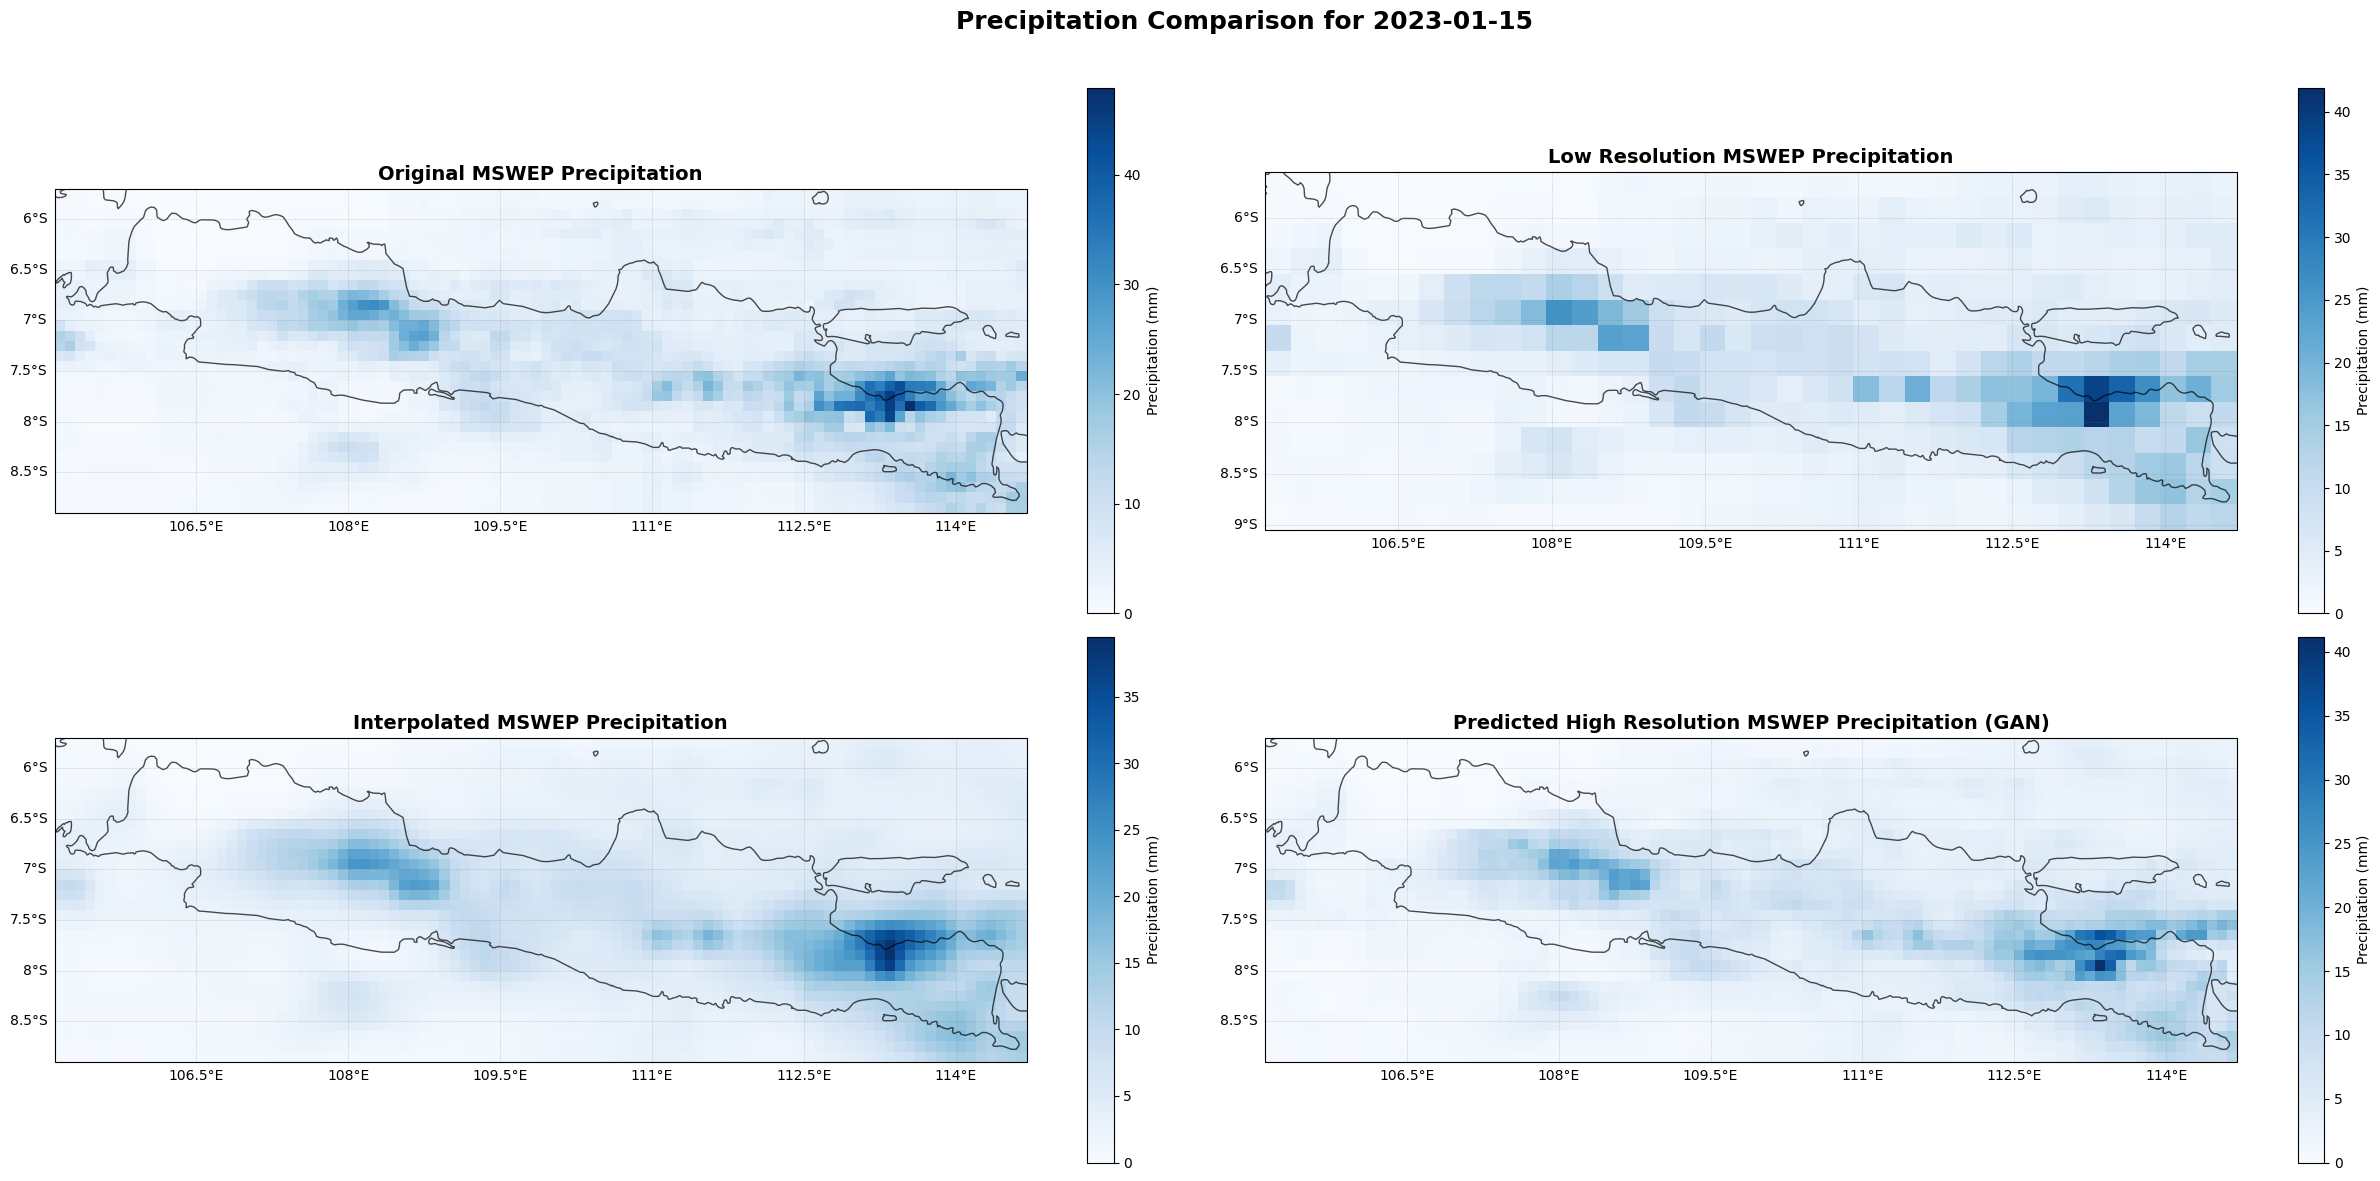

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Pilih tanggal spesifik untuk visualisasi
specificDate = np.datetime64('2023-01-15')  # Sesuaikan dengan tanggal target Anda

# Convert to XARRAY object
dsOriginal = image2Xarray(precipTestOriginal[:,:,:,0], lonOriginal, latOriginal, timeOriginalTest)
dsLowRes = image2Xarray(precipLowResTest[:,:,:,0], lonLowRes, latLowRes, timeLowResTest)
dsHighRes = image2Xarray(precipHighResTest[:,:,:,0], lonHighRes, latHighRes, timeHighResTest)
dsPredicted = image2Xarray(yTestPreds[:,:,:,0], lonHighRes, latHighRes, timeHighResTest)

# Extract precipitation data
precipOriginal = selectPrecipitation(dsOriginal, specificDate)
precipLowRes = selectPrecipitation(dsLowRes, specificDate)
precipHighRes = selectPrecipitation(dsHighRes, specificDate)
precipPredict = selectPrecipitation(dsPredicted, specificDate)

# Create figure with Cartopy projection
fig, ax = plt.subplots(2, 2, figsize=(25, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Menggunakan Blues colormap untuk semua plot
cmap_blues = plt.cm.Blues.copy()

# Tetapkan rentang nilai yang berbeda untuk setiap subplot
# Berdasarkan karakteristik masing-masing dataset
vmin = 0  # Nilai minimum sama untuk semua
# vmax_original = 40  
# vmax_lowres = 25
# vmax_interpolated = 25
# vmax_predicted = 35

# max_precip = max(
#     float(precipOriginal.max()), 
#     float(precipLowRes.max()), 
#     float(precipHighRes.max()), 
#     float(precipPredict.max())
# )

# Plot precipitation data dengan rentang nilai yang berbeda untuk setiap plot
precipOriginal.plot(ax=ax[0,0], cmap=cmap_blues, transform=ccrs.PlateCarree(), 
                   vmin=vmin, cbar_kwargs={'label': 'Precipitation (mm)'})
precipLowRes.plot(ax=ax[0,1], cmap=cmap_blues, transform=ccrs.PlateCarree(), 
                 vmin=vmin, cbar_kwargs={'label': 'Precipitation (mm)'})
precipHighRes.plot(ax=ax[1,0], cmap=cmap_blues, transform=ccrs.PlateCarree(), 
                  vmin=vmin, cbar_kwargs={'label': 'Precipitation (mm)'})
precipPredict.plot(ax=ax[1,1], cmap=cmap_blues, transform=ccrs.PlateCarree(), 
                  vmin=vmin, cbar_kwargs={'label': 'Precipitation (mm)'})

# Menambahkan fitur kartografi ke semua subplot
for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(linewidth=1.0, alpha=0.7)
        ax[i,j].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.7, alpha=0.7)
        ax[i,j].add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray', alpha=0.1)
        gl = ax[i,j].gridlines(draw_labels=True, linewidth=0.4, alpha=0.4, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels = False

# Set titles dengan font yang lebih besar
ax[0,0].set_title("Original MSWEP Precipitation", fontsize=14, fontweight='bold')
ax[0,1].set_title("Low Resolution MSWEP Precipitation", fontsize=14, fontweight='bold')
ax[1,0].set_title("Interpolated MSWEP Precipitation", fontsize=14, fontweight='bold')
ax[1,1].set_title("Predicted High Resolution MSWEP Precipitation (GAN)", fontsize=14, fontweight='bold')

# Add overall title with date
plt.suptitle(f"Precipitation Comparison for {np.datetime_as_string(specificDate, unit='D')}", 
             fontsize=18, y=0.98, fontweight='bold')

# Sesuaikan layout untuk mencegah tumpang tindih
plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect=[left, bottom, right, top]
plt.savefig(ReportFolder + '/Graph/6.Example.png', dpi=300, bbox_inches='tight')